In [33]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

# Type of Image Format :
### jpg, jpeg, png, bmp
### BMP - Bitmap Image is a raster image (containing pixel data as opposed to vector images) format. Each pixel of a bitmap image is defined by a single bit or a group of bits. Hence, it is called the bitmap or a map of bits and pixels. It was designed by Microsoft Corporation to easily exchange images between different devices without worrying about the device’s logic to display raster images on the screen.

160


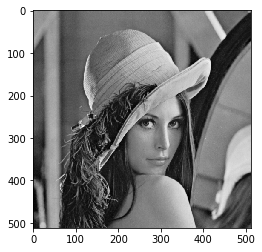

In [3]:
# Difference While using Different Formats of Images 

#While using BMP format the pixel value are in the form of integers

img_bmp = r'C:\Users\Janardhan\Desktop\Image-Cryptography\lena.bmp' # Taking an BMP file format Image Path
im = Image.open(img_bmp) 
plt.imshow(np.asarray(im),cmap='gray')
pix = im.load()
print(pix[0,0]) # When displaying each Pixel has a fixed Integer Value

(95, 50, 27)


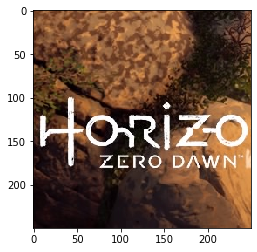

In [30]:
# Difference While using Different Formats of Images 

#While using any other formats (PNG, JPG, JPEG etc.,) the pixel value are in the form of vectors of (RGB) in the form of Tuple

img_png = r'C:\Users\Janardhan\Desktop\Image-Cryptography\HorizonZero.png'
im = Image.open(img_png) 
plt.imshow(np.asarray(im))
pix = im.load()
print(pix[0,0]) # When displaying each Pixel is displays a vector form of (RGB) in the form of tuple

In [5]:
# Coverting Original Image to Matrix of Pixels

def getImageMatrix(imageName): # Passing Image Path as parameter
    im = Image.open(imageName) 
    pix = im.load()
    
    # TO MAKE THE CODE UNIVERSAL TO WORK FOR ALL TYPES OF FILE FORMATS
    
    # We are checking if the pixels are in Integer format or Tuple Format
    flag = 1 # Used for checking if the Pixels are (RGB-Format which is a Tuple) or (Single Color Format which is Int)
    if type(pix[0,0]) == int:
      flag = 0
    
    image_size = im.size # Gives number of rows and columns as a tuple (row,column)
    image_matrix = []
    
    for width in range(int(image_size[0])):
        row = []
        for height in range(int(image_size[1])):
                row.append((pix[width,height]))
        image_matrix.append(row) #[[1,2,3],[1,2,3]]
    
    # Instead of using the for loop we can use simple Numpy Function to convert Image to Matrix
    # image_matrix = np.array(imageName)
    return image_matrix,image_size[0],flag # returning Image Matrx, Row size, flag (Type of color format)

# Creating Image Matrix in Gray Scale 
def getImageMatrix_gray(imageName):
    im = Image.open(imageName).convert('LA') # this function reads an image into grayscale rather than color
    pix = im.load()
    image_size = im.size 
    image_matrix = []
    for width in range(int(image_size[0])):
        row = []
        for height in range(int(image_size[1])):
                row.append((pix[width,height]))
        image_matrix.append(row)
    return image_matrix,image_size[0]

In [6]:
# Used to convert bits into Decimal
def dec(bitSequence):
    decimal = 0
    for bit in bitSequence:
        decimal = decimal * 2 + int(bit) # Bit is converted into Decimal by multiplying with 2
    return decimal # return the decimal from bits

# Used to get Henon Matrix
def genHenonMap(dimension, key): # sending X0 and Y0 initial values in key tuple
    x = key[0] 
    y = key[1]
    sequenceSize = dimension * dimension * 8 #Total Number of bitSequence rows * columns * bits per pixel
    bitSequence = []    #Each element takes 8 bits (8 bits per pixel)
    # each element = 8 bits
    # 8 bit sequence forms byte
    # byte array contain 8 bytes
    byteArray = []      #Each byteArray contains m (i.e 8*8*8 = 512 in this case) bitSequence
    TImageMatrix = []   #Each TImageMatrix contains m*n byteArray
    for i in range(sequenceSize):
        xN = y + 1 - 1.4 * x**2
        yN = 0.3 * x

        x = xN
        y = yN

        if xN <= 0.4: # 0.3992 approx 0.4 according to threshold value
            bit = 0
        else:
            bit = 1

        try: # works without try and except block
            bitSequence.append(bit)
        except: # just for safety if in case any errors occur
            bitSequence = [bit]

        if i % 8 == 7:
            decimal = dec(bitSequence)
            try:
                byteArray.append(decimal)
            except:
                byteArray = [decimal]
            bitSequence = []

        byteArraySize = dimension*8
        if i % byteArraySize == byteArraySize-1:
            try:
                TImageMatrix.append(byteArray)
            except:
                TImageMatrix = [byteArray]
            byteArray = []
    return TImageMatrix # Henon Matrix

In [7]:
# Now we got both Image Matrix and Henon Matrix so we can perform Encryption and Decryption

In [8]:
# Encryption is obtained by multiplication of Image Matrix and Henon Matrix with specific Key of our choice

def HenonEncryption(imageName,key):
    imageMatrix, dimension, flag = getImageMatrix(imageName) # get Image Matrix 
    transformationMatrix = genHenonMap(dimension, key) # get Henon Matrix
    
    resultantMatrix = [] # to store the resultant Matrix of Pixels
    
    # Performing XOR operation by multiplying matrixes of Image and Henon
    
    # In python ^ operator is used as XOR operation
    for i in range(dimension):
        row = []
        for j in range(dimension):
            try:
                if flag:
                    # Since the pixels are in tuple format we are iterating over the tuple 
                    row.append(tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]])) # while using RGB colors
                else:
                    # Since the pixels are in integer format no interation is required we can proceed to simple xor operation
                    row.append(transformationMatrix[i][j] ^ imageMatrix[i][j]) # while using single channel colors
            except: 
                if flag:
                    row = [tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]])]
                else :
                    row = [transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]
        try:    
            resultantMatrix.append(row) # appending rows to matrix
        except:
            resultantMatrix = [row]
    if flag: # for RGB channel color 
      im = Image.new("RGB", (dimension, dimension)) # creating color image object
    else: 
      im = Image.new("L", (dimension, dimension)) # creating black and white image object (L is for Black and white pixels)

    pix = im.load()
    
    # Converting the Matrix of Pixels to Image which results in Encrypted Image
    for x in range(dimension):
        for y in range(dimension):
            pix[x, y] = resultantMatrix[x][y]
            
    im.save(imageName.split('.')[0] + "_HenonEnc.png", "PNG") # Saves the image where the original Image was taken

In [9]:
# Decryption is obtained by Matrix multiplication of Image Matrix and Henon Matrix passing the key specified to obtain retrival

def HenonDecryption(imageNameEnc, key):
    imageMatrix, dimension, flag = getImageMatrix(imageNameEnc)
    transformationMatrix = genHenonMap(dimension, key)

    henonDecryptedImage = [] # to store resultant matrix
    
    for i in range(dimension):
        row = []
        for j in range(dimension):
            try:
                if flag:
                    row.append(tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]))
                else:
                    row.append(transformationMatrix[i][j] ^ imageMatrix[i][j])
            except:
                if flag:
                    row = [tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]])]
                else :
                    row = [transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]
        try:
            henonDecryptedImage.append(row)
        except:
            henonDecryptedImage = [row]
    if flag:
        im = Image.new("RGB", (dimension, dimension))
    else: 
        im = Image.new("L", (dimension, dimension)) # L is for Black and white pixels

    pix = im.load()
    
    # converting Matrix to Image
    for x in range(dimension):
        for y in range(dimension):
            pix[x, y] = henonDecryptedImage[x][y]
            
            
    im.save(imageNameEnc.split('_')[0] + "_HenonDec.png", "PNG") # saving image in the same location

## Working of Henon Map with .PNG File Format

In [10]:
image = r'C:\Users\Janardhan\Desktop\Image-Cryptography\HorizonZero' # Path of the file Image
ext = ".png"
key = (0.1,0.1) # Specifying key (X0,Y0) values

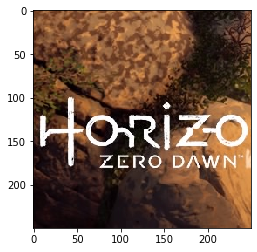

In [11]:
pil_im = Image.open(image + ext, 'r') # opening the Image in Read 'r' Mode
plt.imshow(np.asarray(pil_im)) # using Mathplot lib and Numpy to show the Image

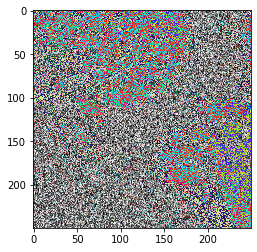

In [12]:
HenonEncryption(image + ext, key) # Sending Image along with the key
im = Image.open(image + "_HenonEnc.png", 'r') 
plt.imshow(np.asarray(im))

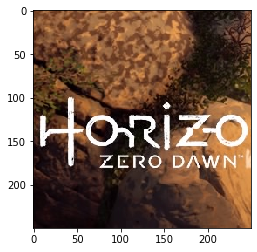

In [13]:
HenonDecryption(image + "_HenonEnc.png", key) # Sending Encrypted Image
im = Image.open(image + "_HenonDec.png", 'r')
plt.imshow(np.asarray(im))

## Working of Henon Map with .BMP File Format

In [14]:
image1 = r'C:\Users\Janardhan\Desktop\Image-Cryptography\lena' # Path of the file Image
ext = ".bmp"
key = (0.1,0.1) # Specifying key (X0,Y0) values

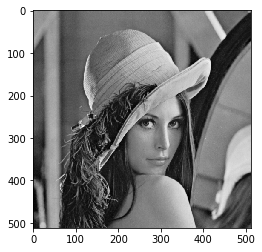

In [15]:
pil_im = Image.open(image1 + ext, 'r') # opening the Image in Read 'r' Mode
plt.imshow(np.asarray(pil_im),cmap='gray') # using Mathplot lib and Numpy to show the Image

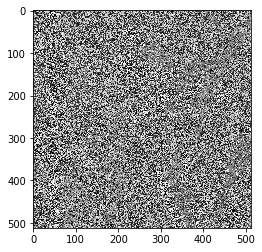

In [16]:
HenonEncryption(image1 + ext, key) # Sending Image along with the key
im = Image.open(image1 + "_HenonEnc.png", 'r') 
plt.imshow(np.asarray(im),cmap='gray')

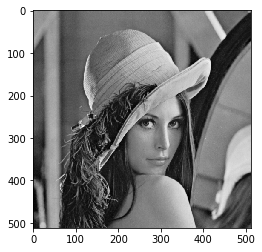

In [17]:
HenonDecryption(image1 + "_HenonEnc.png", key) # Sending Encrypted Image
im = Image.open(image1 + "_HenonDec.png", 'r')
plt.imshow(np.asarray(im),cmap='gray')

# HISTOGRAM AND CORRELATION

## Original Image

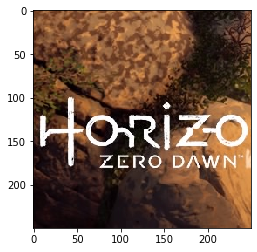

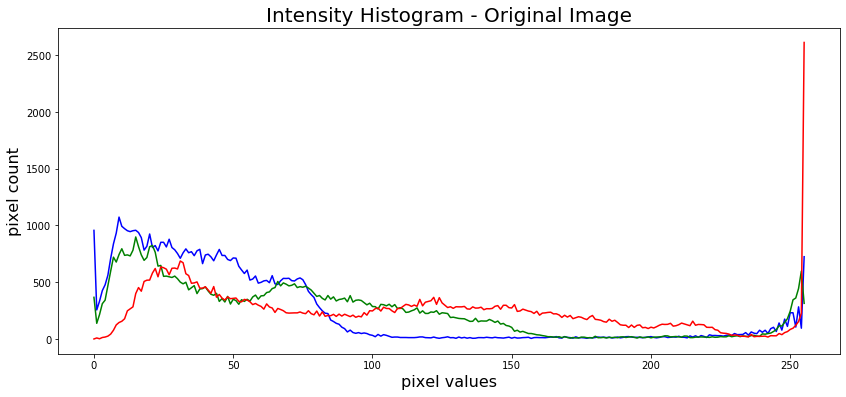

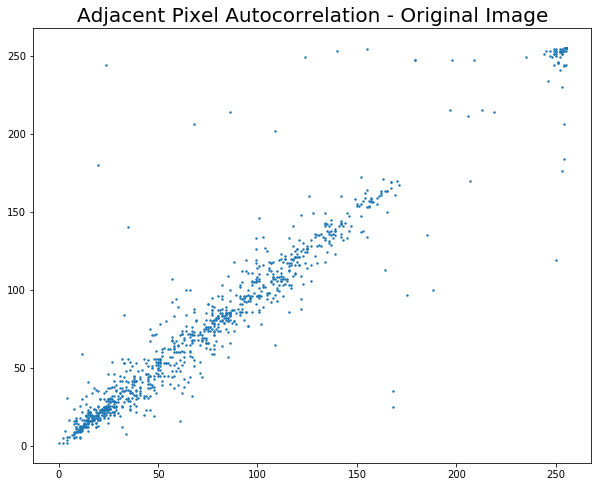

In [45]:
image = r'C:\Users\Janardhan\Desktop\Image-Cryptography\HorizonZero'
ext = ".png"

# DISPLAYING IMAGE

img = cv2.imread(image + ext,1) 
pil_im = Image.open(image + ext, 'r')
plt.imshow(np.asarray(pil_im))
plt.figure(figsize=(14,6))

# HISTOGRAM

# First we need to split the image into channels of Red, Green, Blue 
# Select the Histogram Size = 256
# Select the Histogram Range = (0,256)

# SYNTAX FOR calHist
#calcHist(image, channel, None, Histogram_Size, Histogram_Range)

#Plotting Blue Channel (NOTE : IN OPENCV THE COLOR FORMAT IS 'BGR')
histogram_blue = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(histogram_blue, color='blue')

#Plotting Green Channel
histogram_green = cv2.calcHist([img],[1],None,[256],[0,256]) 
plt.plot(histogram_green, color='green')

#Plotting Red Channel
histogram_red = cv2.calcHist([img],[2],None,[256],[0,256]) 
plt.plot(histogram_red, color='red') 

plt.title('Intensity Histogram - Original Image', fontsize=20) # Adding Title
plt.xlabel('pixel values', fontsize=16) # Adding X-Axis
plt.ylabel('pixel count', fontsize=16) # Adding Y-Axis
plt.show() # SHOW


# CORRELATION

ImageMatrix,image_size = getImageMatrix_gray(image+ext) # Getting image matrix

samples_x = []
samples_y = []

for i in range(1000): # Selecting 1000 points 
  x = random.randint(0,image_size-2) # Gives random value 
  y = random.randint(0,image_size-1) # Gives random value
    
  samples_x.append(ImageMatrix[x][y])
  samples_y.append(ImageMatrix[x+1][y]) # comparing horizontally, for vertical comparision [x][y+1], for diagonal [x+1][y+1]

plt.figure(figsize=(10,8))
plt.scatter(samples_x,samples_y,s=2)
plt.title('Adjacent Pixel Autocorrelation - Original Image', fontsize=20)
plt.show()

## Encrypted Image

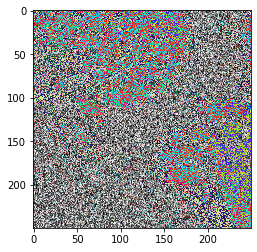

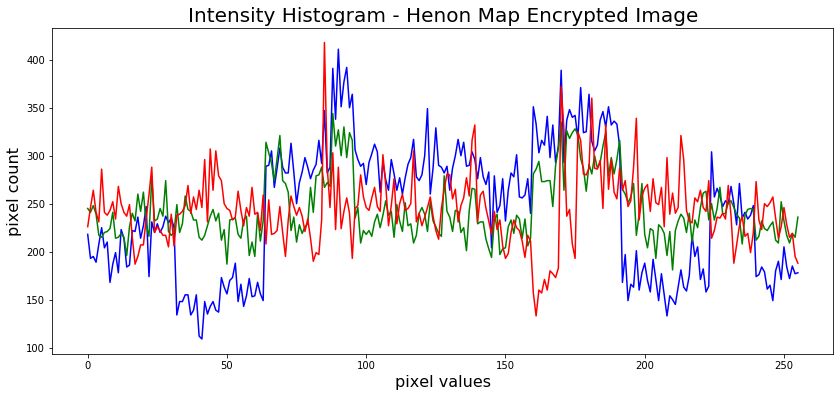

250


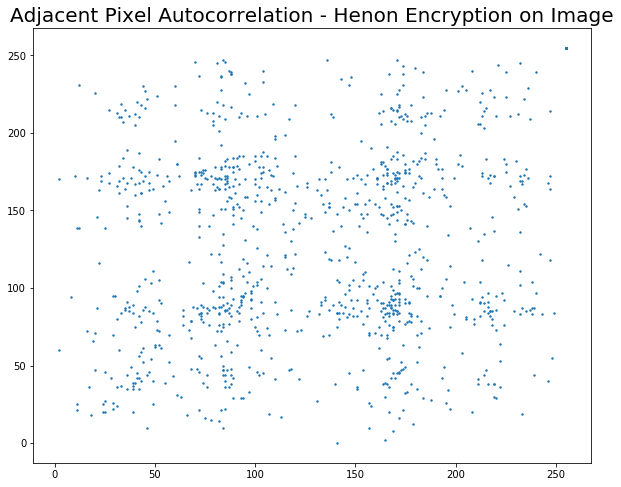

In [52]:
image = r'C:\Users\Janardhan\Desktop\Image-Cryptography\HorizonZero_HenonEnc'
ext = ".png"

# DISPLAYING IMAGE 

img = cv2.imread(image + ext,1) 
pil_im = Image.open(image + ext, 'r')
plt.imshow(np.asarray(pil_im))
plt.figure(figsize=(14,6))

# HISTOGRAM

histogram_blue = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(histogram_blue, color='blue') 
histogram_green = cv2.calcHist([img],[1],None,[256],[0,256]) 
plt.plot(histogram_green, color='green') 
histogram_red = cv2.calcHist([img],[2],None,[256],[0,256]) 
plt.plot(histogram_red, color='red') 
plt.title('Intensity Histogram - Henon Map Encrypted Image', fontsize=20)
plt.xlabel('pixel values', fontsize=16)
plt.ylabel('pixel count', fontsize=16) 
plt.show()

# CORRELATION

ImageMatrix,image_size = getImageMatrix_gray(image+ext)
samples_x = []
samples_y = []
print(image_size)
for i in range(1000):
  x = random.randint(0,image_size-2)
  y = random.randint(0,image_size-2)
  samples_x.append(ImageMatrix[x][y])
  samples_y.append(ImageMatrix[x][y+1])
plt.figure(figsize=(10,8))
plt.scatter(samples_x,samples_y,s=2)
plt.title('Adjacent Pixel Autocorrelation - Henon Encryption on Image', fontsize=20)
plt.show()